In [1]:
import heapq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat

In [2]:
class AreaSimulation:
    """
    Class for the simulation of the irrigation area.
    
    ...
    
    
    Attributes
    ----------
    xk_initial : np.ndarray
        Initial values for the state variables.
    xk_array : np.ndarray
        Array to collect all measurements in the state variables.
    ir_array : np.ndarray
        Array for the input variables.
    Kc : float
        Crop constant.
    control_high : float
        High control level of humidity.
    control_low : float
        Low control level of humidity.
    irrigation_value : float
        Irrigation value for the area.
    eto_array : np.ndarray
        Array to collect ETO information from the plant.
    t_array : np.ndarray
        Time array.
    hydric_stress : float
        Percentage of time where the plant is under stress.
    total_water : float
        Total water used.
        
    Methods
    -------
    irrigation_dynamics_function(xk_initial, Kc, control_high, control_low, irrigation_value)
        Returns the next state for the system.
    get_deadline()
        Calculates the dynamic deadline priority for irrigation.
    run(filename)
        Runs the simulation to collect information for the plant in the simulation period.
    display(title)
        Display a graph with the system dynamics.
    """
 
    def __init__(self, xk_initial: np.ndarray, Kc: float, control_high: float,
                 control_low: float, irrigation_value: float):
        """
        Parameters
        ----------
        xk_initial : np.ndarray
            Initial values for the state variables.
        Kc : float64
            Crop constant.
        control_high : float
            High control level of humidity.
        control_low : float
            Low control level of humidity.
        irrigation_value : float
            Irrigation value for the area.
        """
        
        self.xk_initial = xk_initial
        self.xk_array = np.empty(0)
        self.ir_array = np.empty(0)
        self.Kc = Kc
        self.control_high = control_high
        self.control_low = control_low
        self.irrigation_value = irrigation_value
        self.eto_array = np.empty(0)
        self.t_array = np.empty(0)
        self.hydric_stress = 0.0
        self.total_water = 0.0

    def irrigation_dynamics_function(self, xk_initial: np.ndarray, ir_act: np.ndarray,
                                     eto_act: float, Kc: float) -> np.ndarray:
        """
        Parameters
        ----------
        xk_initial : np.ndarray
            Initial values for the state variables.
        ir_act : np.ndarray
            Values for the input variables.
        eto_act : float
            Present value of the ETO.
        Kc : float
            Crop constant.
        """
        
        # State and input matrices for the different levels of earth moisture.
        A_above = np.array([[0.98501, 0.00001], [0.00001, 0.98501]])
        A_middle = np.array([[1.00000, 0.00001], [0.00001, 0.98501]])
        A_below = np.array([[1.00000, 0.00001], [0.00001, 0.98501]])

        B_above = np.array([[0.00245, -0.00004], [0.00300, -0.00020]])
        B_middle = np.array([[0.00135, -0.00060], [0.00325, -0.00050]])
        B_below = np.array([[0.00125, -0.00005], [0.00150, -0.00035]])

        # Not used.
        C = np.array([1, 0])

        # Threshold levels.
        high_limit = 7.0
        low_limit = -7.0
        high_threshold = 5.0
        low_threshold = -5.0

        # State and input variables.
        xk_act = xk_initial
        uk_act = np.array([ir_act, Kc*eto_act], dtype=object)

        xk_next = np.empty(2)

        # Control action.
        if xk_act[0] > high_threshold:
            xk_next = np.dot(A_above, xk_act) + np.dot(B_above, uk_act)
        elif xk_act[0] > low_threshold:
            xk_next = np.dot(A_middle, xk_act) + np.dot(B_middle, uk_act)
        else:
            xk_next = np.dot(A_below, xk_act) + np.dot(B_below, uk_act)
            
        if xk_next[0] > high_limit:
            xk_next[0] = high_limit
        elif xk_next[0] < low_limit:
            xk_next[0] = low_limit

        return xk_next
    
    def get_deadline(self, t: int) -> int:
        """
        Parameters
        ----------
        t : int
            Moment from where deadline is estimated.
        """
        
        deadline = float('inf')
        states = self.xk_initial
        
        if states[0] < self.control_low:
            deadline = 0
            while states[0] < self.control_high:
                states = self.irrigation_dynamics_function(states, self.irrigation_value,
                                                            self.eto_array[t], self.Kc)
                deadline += 1
            
        return deadline
    
    def start(self, filename: str) -> None:
        """
        Parameters
        ----------
        filename : str
            Path location for the .mat with the ETO information.
        """
        
        # Load file into 'eto_array' variable.
        data = loadmat(filename)
        self.eto_array = data['eto_array']
        
        simulation_period = self.eto_array.size
        self.t_array = np.arange(simulation_period)
        
        # Initialize variables for the simulation.
        self.xk_array = np.empty([2, simulation_period])
        self.ir_array = np.empty([simulation_period])
        self.ir_array[0] = 0.0
        
    def run(self, t: int, turn: bool) -> None:
        """
        Parameters
        ----------
        t : str
            Current time.
        turn : bool
            Is it its irrigation turn?
        """
        
        if not turn or t == 0:
            self.ir_array[t] = 0
        elif turn and self.xk_initial[0] < self.control_low:
            self.ir_array[t] = self.irrigation_value
        else:
            self.ir_array[t] = self.ir_array[t-1]
        
        xk_next = self.irrigation_dynamics_function(self.xk_initial, self.ir_array[t],
                                                    self.eto_array[t], self.Kc)
        if self.xk_initial[0] < self.control_low:
            self.hydric_stress += 1.0

        self.xk_initial = xk_next
        self.xk_array[0, t] = xk_next[0]
        self.xk_array[1, t] = xk_next[1]

        self.total_water += self.ir_array[t]
            
    def display(self, title: str) -> None:
        """
        Parameters
        ----------
        title : str
            Name for the plot title.
        """
        
        simulation_period = self.eto_array.size
        
        # Generate a plot with the information from the system dynamics.
        plt.title(title)
        plt.plot(self.t_array, self.xk_array[0], 'b-', 
                 self.t_array, np.zeros(simulation_period), 'k--',
                 self.t_array, self.control_high*np.ones(simulation_period), 'k:',
                 self.t_array, self.control_low*np.ones(simulation_period), 'k:')
        plt.axis([0, simulation_period, -8, 8])
        
        plt.show()
    
def run(areas: list[AreaSimulation]):
    
    simulation_period = areas[0].eto_array.size
    
    index = 0
    deadlines = [(a.get_deadline(0), i) for i, a in enumerate(areas)]
    heapq.heapify(deadlines)
    
    priority = deadlines[index][1]
    
    turn = [False] * len(areas)
    turn[priority] = True
    
    for t in range(simulation_period):  
        for i, a in enumerate(areas):
            a.run(t, turn[i])
        
        if areas[priority].xk_array[0, t] >= areas[priority].control_high:
            turn[priority] = False
            deadlines = [(a.get_deadline(0), i) for i, a in enumerate(areas)]
            heapq.heapify(deadlines)
            priority = deadlines[index][1]   
            turn[priority] = True
    
    # Normalize the hydric stress and total water variables.
    for a in areas:
        a.hydric_stress /= simulation_period
        a.total_water /= 1000.0
    

In [3]:
# Initialize empty array for the four areas.
Areas = list()

# Values for the parameters in all areas.
xk_initial = [np.array([5.0, 0.0]), np.array([2.0, 0.0]),
               np.array([2.0, 0.0]), np.array([-2.0, 0.0])]
Kc = [1.0, 1.2, 1.4, 0.8]
control_high = [5.0, 1.0, 2.0, 4.0]
control_low = [-5.0, -1.0, -2.0, -4.0]
irrigation_value = [40.0, 45.0, 35.0, 40.0]

# Path location for the ETO .mat file.
filename = "matlab_programs/DataSet_ETO_45_days.mat"

threads = list()

# Initialize, run, and display the results of the individual areas with multithreading.
for i in range(4):
    Areas.append(AreaSimulation(xk_initial=xk_initial[i], Kc=Kc[i],
                                control_high=control_high[i], control_low=control_low[i],
                                irrigation_value=irrigation_value[i]))
    Areas[i].start(filename)

run(Areas)
    
cs = pd.DataFrame(Areas[2].xk_array[0])
cs.to_csv("Case E.csv")

d = {"Time Under Hydric Stress (%)": [area.hydric_stress * 100.0 for area in Areas],
     "Cubic Meters of Water Used (m^3)": [area.total_water for area in Areas]}
df = pd.DataFrame(data=d, index=pd.Index([i+1 for i in range(len(Areas))], name="Irrigation Area:"))
df

,Time Under Hydric Stress (%),Cubic Meters of Water Used (m^3)
Irrigation Area:,,
1,0.020062,107.04
2,75.824074,69.03
3,69.209877,78.19
4,22.177469,74.56


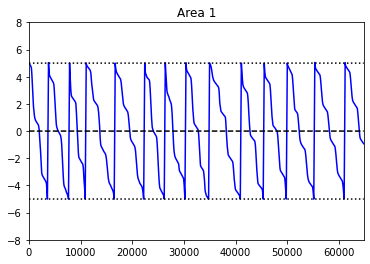

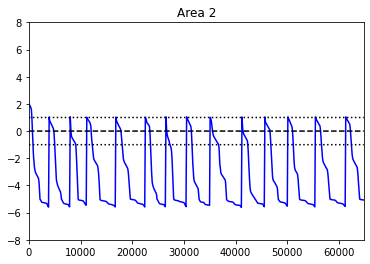

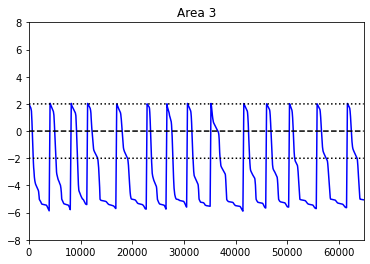

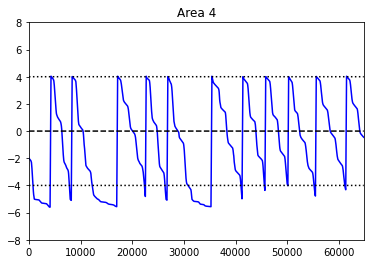

In [4]:
for i, area in enumerate(Areas):
    area.display(f"Area {i+1}")